<a href="https://colab.research.google.com/github/rakesh4real/rollmodels/blob/main/keras2onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper Functions

In [9]:
"""
## 1. Setup
"""

import matplotlib.pyplot as plt
import time
import seaborn as sns


"""
# 2. Random Image
"""

def get_and_plot_random_image_from(x_test, y_test):

    # get a random image index from the test set
    image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
    expected_label = y_test[image_index]
    digit_image = x_test[image_index]
    # and plot it
    plt.title(f'Example {image_index} Label: {expected_label}')
    plt.imshow(digit_image.squeeze(2), cmap='Greys')
    plt.show()
    return digit_image, image_index


"""
# 3. Inference w/o onnx
"""

def infer_w_raw_h5(digit_image, expected_label, model, input_shape, loop_count=1000):
    # reshape the image for inference/prediction
    #digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], 1)
    digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], input_shape[2])

    # loop `loop_count` times
    times = np.array([])
    for i in range(loop_count):
      if i<100:
        prediction_probabs = model.predict(digit_image)
      else:
        start_time = time.time()
        prediction_probabs = model.predict(digit_image)
        times = np.append(times, (time.time() - start_time))
    print(f"Keras inferences with {times.mean()} +- {times.std()} second in average")

    print("="*60)
    print("Prediction probabilities:")
    print(prediction_probabs)
    print("="*60)

    if expected_label is None:
      return prediction_probabs, times.mean()

    predicted_label = prediction_probabs.argmax()
    print('Predicted value:', predicted_label)


    is_correct_pred = None
    if (expected_label.argmax() == predicted_label):
      print('Correct prediction')
      is_correct_pred = True
    else:
      print('Wrong prediction')
      is_correct_pred = False

    # can be used for more control (see suggestio where used)
    return (is_correct_pred, prediction_probabs), times.mean()


"""
# 4. Inference w/ onnx

!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx
"""


!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

import onnxruntime
import keras2onnx

def h52onnx(model, output_onnxmodel_path='./onnx_model.onnx'):
  print("keras2onnx version is "+keras2onnx.__version__)
  save_name = output_onnxmodel_path.split(".onnx")[0].split("/")[-1] # get name from path
  print(save_name)
  # convert to onnx model
  onnx_model = keras2onnx.convert_keras(model, save_name, debug_mode=1)
  # and save the model in ONNX format
  keras2onnx.save_model(onnx_model, output_onnxmodel_path)


def generate_data_feed_and_sess(digit_image, input_shape, output_onnxmodel_path):
    # reshape the image for inference/prediction
    #digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], 1)
    digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], input_shape[2])
    
    # define session (include options using docs if necessary)
    sess_options = onnxruntime.SessionOptions()
    sess = onnxruntime.InferenceSession(output_onnxmodel_path, sess_options)
    # define data
    data = [digit_image.astype(np.float32)]
    # feed data
    input_names = sess.get_inputs()
    feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])
    return feed, sess
    

def infer_w_onnx_runtime(digit_image, expected_label,
                         input_shape,
                         output_onnxmodel_path='./onnx_model.onnx',
                         loop_count=1000):
  # setup
  feed, sess = generate_data_feed_and_sess(digit_image, input_shape, output_onnxmodel_path)

  # calculate average
  times = np.array([])
  for i in range(loop_count):
    if i<100:
      # note: session is used to make preds
      onnx_prediction_probabs = sess.run(None, feed)[0]
    else:
      start_time = time.time()
      # note: session is used to make preds
      onnx_prediction_probabs = sess.run(None, feed)[0]
      times = np.append(times, (time.time() - start_time))
  print(f"ONNX inferences with {times.mean()}+-{times.std()} second in average")

  # compare w/ raw h5
  print("="*60)
  print("[onnx]Prediction probabilities:")
  print(onnx_prediction_probabs)
  print("="*60)

  if expected_label is None:
    return onnx_prediction_probabs, times.mean()

  is_correct_pred = None
  print('ONNX predicted value:', onnx_prediction_probabs.argmax())
  if (expected_label.argmax() == onnx_prediction_probabs.argmax()):
    print('Correct prediction')
    is_correct_pred = True
  else:
    print('Wrong prediction')
    is_correct_pred = False

  return (is_correct_pred, onnx_prediction_probabs), times.mean()

# **Part 1:** Lighter Models

# Create Keras .h5 Model

- Makes sure input dims is given in first layer

In [5]:
input_shape = (28, 28, 1)

# Important while creating keras model, making inference w and w/o keras (onnx)

In [6]:
"""
## Setup
"""
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
print("TensorFlow version is "+tensorflow.__version__)


SEED = 101
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

"""
## Build the model
"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape), # !NOTE: input shape must be defined @beg to avoid onnx errors
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

"""
## Train the model
"""

os.makedirs("keras_saved_model", exist_ok=True)
checkpoint_filepath = 'keras_saved_model/model.h5'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # else, error
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



batch_size = 128
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[model_checkpoint_callback])

"""
## Evaluate the trained model
"""

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

TensorFlow version is 2.3.0
11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)     

# Load and eval best.h5 model

In [7]:
# best models
model = tensorflow.keras.models.load_model(checkpoint_filepath)

# eval
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.030294399708509445
Test accuracy: 0.9894999861717224


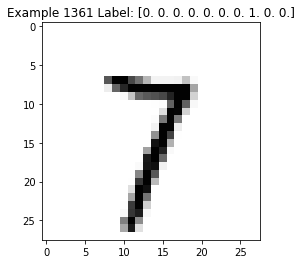

Keras inferences with 0.03899029466840956 +- 0.011481399935370885 second in average
Prediction probabilities:
[[1.0396517e-08 3.8510469e-05 5.8069350e-06 1.1702822e-05 1.3604573e-10
  1.0016728e-08 2.0226464e-13 9.9993026e-01 2.7603714e-06 1.0925553e-05]]
Predicted value: 7
Correct prediction


In [10]:
# a. get random image
digit_image, digit_idx = get_and_plot_random_image_from(x_test, y_test)

# b. loop inference for avg. inference time
(_, keras_prbs_100it), keras_time_100it = infer_w_raw_h5(digit_image, expected_label=y_test[digit_idx],
                                                              model=model, input_shape=input_shape)

# SUGGESTION: For more control, as this is for single, image, 
# Go one step further by putiing the above two functions 
# in loop as well and take average

# Conversion from Keras to ONNX


In [11]:
h52onnx(model, "./keras-mnist-optimized.onnx") # saves in curdir

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Softmax_1:0
	input : dropout/cond_1/Identity:0
Processing a keras layer - (dropout: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout/cond_1/Identity:0
	input : flatten/Reshape_1:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape_1:0
	input : max_pooling2d_1/MaxPool_1:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool_1:0
	input : conv2d_1/Relu_1:0
Processing a keras layer - (conv2d_1: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>)
	output: conv2d_1/Relu_1:0
	input : max_pooling2d/MaxPool_1:0
Processing a keras layer - (max_pooling2d: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d/MaxPool_1

keras2onnx version is 1.7.1
keras-mnist-optimized
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense 

# Evaluate the ONNX's Model Performance

In [12]:
(_, onnxs_prbs_100it), onnx_time_100it = infer_w_onnx_runtime(digit_image, expected_label=y_test[digit_idx], 
                                                              input_shape=input_shape,
                                                              output_onnxmodel_path='./keras-mnist-optimized.onnx') # same path as used above to load

ONNX inferences with 0.00021988418367173935+-0.00030304187300324434 second in average
[onnx]Prediction probabilities:
[[1.03964766e-08 3.85104322e-05 5.80693495e-06 1.17028221e-05
  1.36045716e-10 1.00167084e-08 2.02265396e-13 9.99930263e-01
  2.76037144e-06 1.09255425e-05]]
ONNX predicted value: 7
Correct prediction


# Comaprision of inference time and model size

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


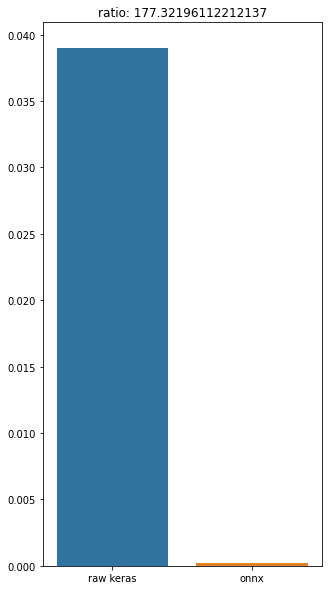

In [25]:
plt.figure(figsize=(5, 10))
sns.color_palette("husl", 8)
sns.barplot(
    ["raw keras", "onnx"],
    [keras_time_100it, onnx_time_100it],
)


plt.title(f"ratio: {keras_time_100it/onnx_time_100it}")
plt.show()

In [26]:
print(onnxs_prbs_100it)
print(keras_prbs_100it)

# Note no change in prediction probabs

[[1.03964766e-08 3.85104322e-05 5.80693495e-06 1.17028221e-05
  1.36045716e-10 1.00167084e-08 2.02265396e-13 9.99930263e-01
  2.76037144e-06 1.09255425e-05]]
[[1.0396517e-08 3.8510469e-05 5.8069350e-06 1.1702822e-05 1.3604573e-10
  1.0016728e-08 2.0226464e-13 9.9993026e-01 2.7603714e-06 1.0925553e-05]]


In [27]:
# Note no change in prediction probabs
def get_size(model_file_path='saved_model.pb'):
  size = os.path.getsize(model_file_path)
  return round(size/(1024.0),3)

print("Raw keras .h5 \t:", get_size('keras_saved_model/model.h5'), "KB")
print("onnx optimized \t:", get_size('keras-mnist-optimized.onnx'), "KB")

Raw keras .h5 	: 443.758 KB
onnx optimized 	: 138.607 KB


- No change in number of parameters
- No change is prediction probabilities
- Speed increased sustantially
- Size decreased substantially 

# **Part 2:** Let's Get Heavy

- Pretrained VGG16

In [30]:
# if expired, regenerate link from `https://www.kaggle.com/l0new0lf/dogs-vs-cats-classification-vgg16-fine-tuning/output?select=vgg16_epoch1_dogcat.h5`
!curl -O https://www.kaggleusercontent.com/kf/45316047/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..cHkJP_KEdg0AKgIkAecj7w.G_fGjRIN18EzXtB0qHz6gH4C19QLk_IeO3sZZ8-JDr3iJ17GYQjrVUFYH8JJsBU23oTta2ZC7sg0jyiNwchPuCTR6OQxxJcy_JiMfg7iAMQKzLZQxWk60iDkYycH6ESUVrK8jvfRLS5KV5XrrR0G3Lozp00xYxKX5fc1TkVc44HpxeToe6ViorU5XgPXS9fCEw6dA1mdsUisZ3dsWz1FTfYlGvyjIJHc9XdMJIbspeadaL1DVR8_qVfmK40Wk7aCC37W1nwzmOEgjgCFXSp1n1Mi6LlsDjDuZFriJ-rQ8FXS_h_s7xD5kU9WTagX3oXw0cDBqZI-BT9LEto2VzRXjuzLVX9j0VzrYMRImSWruHbp0dXOlilCXzi-66Y1Ql2M65Whz7mjq7n3AgnjggoWmZwNA-KY-imhTdfA-FvnOrxf2w-dYcjEKBqqdKVUoMzmRn_7gOhe4fwzWiiumhugij9pKTzlA7Ok7WVwk1DDdP2H_lom71x9tLIxoBLIF1gFNJTaJvjiQsD6bHqp5ewpnMd0Kj9dtq1ENZEsqrWprZD3dbnmJi7yEqujvf8bZsG4tGJmwrZKIo8o3BJhDnkz5489ZyFvzUP42csrz-pB4TO0Y0sgynjVkWVIKj2sqVcc4FcsrXQVwahM8h7hdhQZAYlgpIuhgDvSCjyM6hh-O1Y.rMW9QVjTp4VoL3bKXmxJuw/vgg16dogcat_ep1_model.h5
!curl -O 'https://raw.githubusercontent.com/rakesh4real/Applied-Machine-Learning/master/Resources/hosted/dog.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 85.2M  100 85.2M    0     0  14.1M      0  0:00:06  0:00:06 --:--:-- 17.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  405k  100  405k    0     0  2815k      0 --:--:-- --:--:-- --:--:-- 2834k


(1440, 1920, 3)


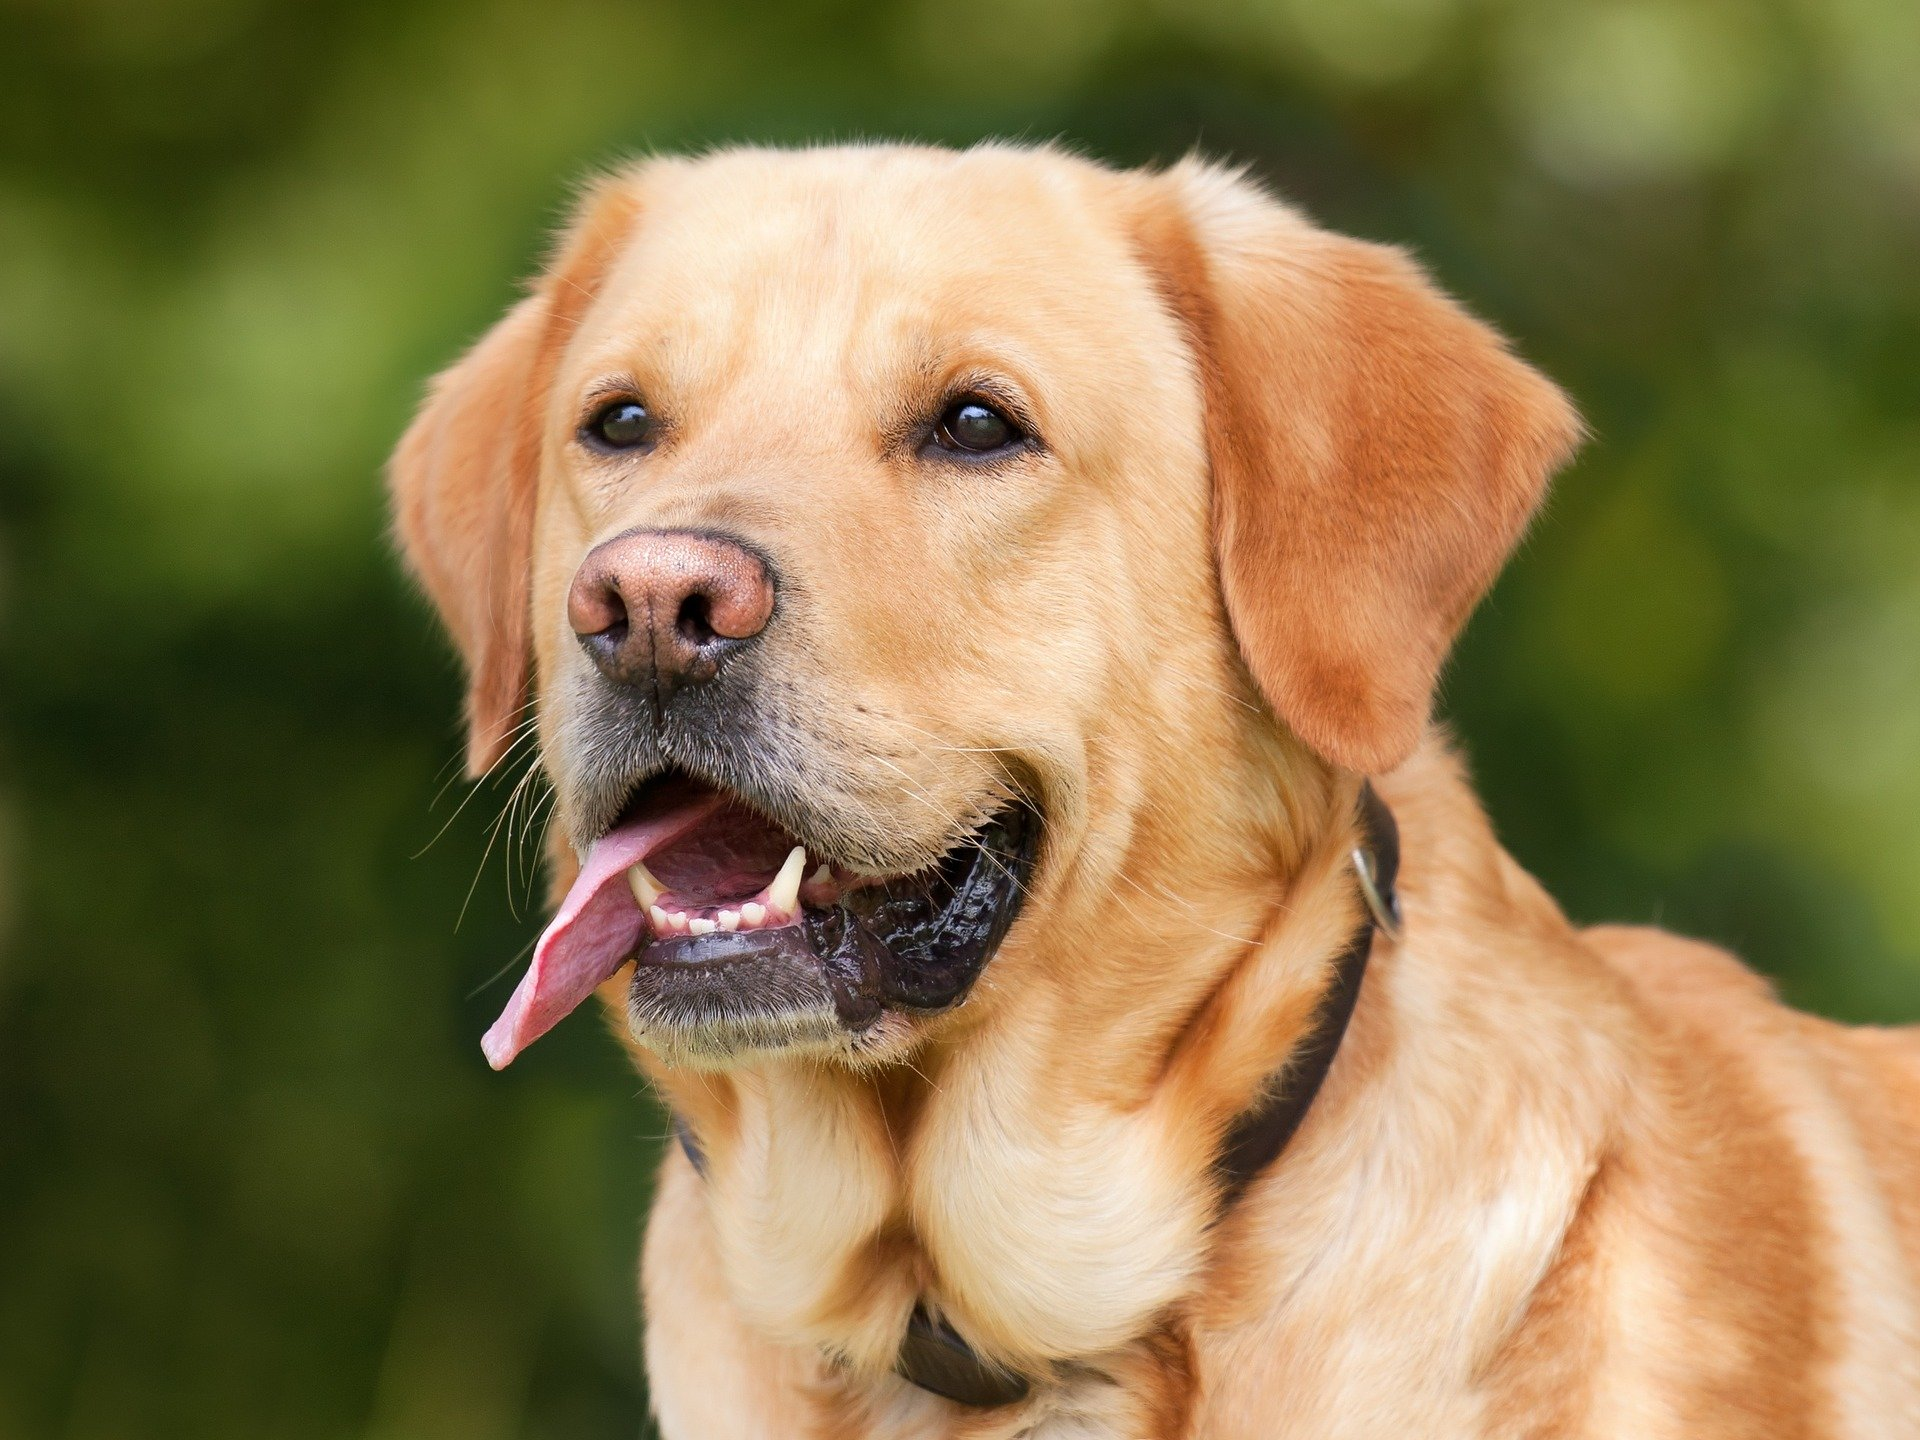

In [31]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('dog.jpg')
print(img.shape)

cv2_imshow(img)

In [32]:
model = tensorflow.keras.models.load_model("/content/vgg16dogcat_ep1_model.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [33]:
input_shape_with_batch = model.input_shape
input_shape = input_shape_with_batch[1], input_shape_with_batch[2], input_shape_with_batch[3]

input_shape

(224, 224, 3)

# Preprocess Data

In [34]:
input_img = cv2.resize(img, (input_shape[0], input_shape[1]))
input_img = input_img / 255.

# Keras (without optimisation)

In [35]:
keras_probabs, keras_vgg_time_100it = infer_w_raw_h5(
                                        input_img, 
                                        expected_label=None,
                                        model=model, 
                                        input_shape=input_shape
                                      )

Keras inferences with 0.5510844333966574 +- 0.043528470782539595 second in average
Prediction probabilities:
[[3.3890183e-07]]


# Conversion to onnx

In [36]:
h52onnx(model, "./keras-vgg-optimized.onnx") # saves in curdir

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense_2: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_2/Sigmoid:0
	input : dropout_1/cond/Identity:0
Processing a keras layer - (dropout_1: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout_1/cond/Identity:0
	input : dense_1/Relu:0
Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_1/Relu:0
	input : global_max_pooling2d_1/Max:0
Processing a keras layer - (global_max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.GlobalMaxPooling2D'>)
	output: global_max_pooling2d_1/Max:0
	input : block5_pool/MaxPool:0
Processing a keras layer - (block5_pool: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: block5_pool/MaxPool:0
	input : block5_conv3/Relu:0
Processing a keras layer - (block5_conv3: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>)
	output: block5_conv3

keras2onnx version is 1.7.1
keras-vgg-optimized
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

Converting the operator (global_max_pooling2d_1): <class 'tensorflow.python.keras.layers.pooling.GlobalMaxPooling2D'>
Converting the operator (global_max_pooling2d_1/Max/reduction_indices): Const
Converting the operator (block5_pool): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (block5_conv3): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (block5_conv2): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (block5_conv1): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (block4_pool): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (block4_conv3): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (block4_conv2): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (block4_conv1): <class 'tensorflow.python.keras.layers.convolutional

# Inference on optimized

In [37]:
onnx_probabs, onnx_time_100it = infer_w_onnx_runtime(
    input_img, 
    expected_label=None,
    input_shape=input_shape,
    output_onnxmodel_path='./keras-vgg-optimized.onnx') # same path as used above to load

ONNX inferences with 0.5087665584352281+-0.05375321348654349 second in average
[onnx]Prediction probabilities:
[[3.5762787e-07]]


# Comaprision

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


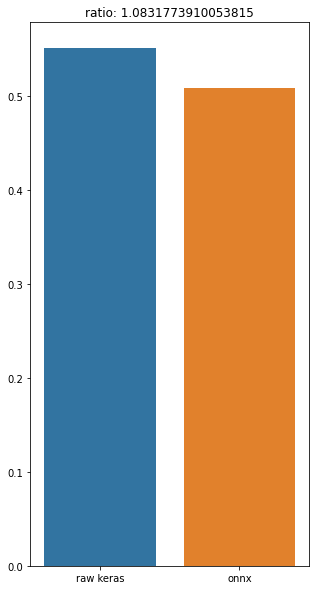

In [38]:
plt.figure(figsize=(5, 10))
sns.color_palette("husl", 8)
sns.barplot(
    ["raw keras", "onnx"],
    [keras_vgg_time_100it, onnx_time_100it],
)


plt.title(f"ratio: {keras_vgg_time_100it/onnx_time_100it}")
plt.show()

> Why?

In [39]:
print(onnx_probabs)
print(keras_probabs)

# Note no change in prediction probabs
def get_size(model_file_path):
  size = os.path.getsize(model_file_path)
  return round(size/(1024.0),3)

print("Raw keras .h5 \t:", get_size('./vgg16_epoch1_dogcat.h5'), "KB")
print("onnx optimized \t:", get_size('./keras-vgg-optimized.onnx'), "KB")

[[3.5762787e-07]]
[[3.3890183e-07]]
Raw keras .h5 	: 0.0 KB
onnx optimized 	: 58517.829 KB


# Pretrained Efficient Net - Not that heavy

In [40]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-bqup5njn
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-bqup5njn
     |████████████████████████████████| 51kB 1.5MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18421 sha256=0908afab29a99ab28b5139c087706d2e73a1f8b54e4ada787c8100ed4c724ccd
  Stored in directory: /tmp/pip-ephem-wheel-cache-twzihz1n/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [41]:
!curl -O https://raw.githubusercontent.com/rakesh4real/Applied-Machine-Learning/master/Resources/hosted/download.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8804  100  8804    0     0  19222      0 --:--:-- --:--:-- --:--:-- 19180


(175, 288, 3)


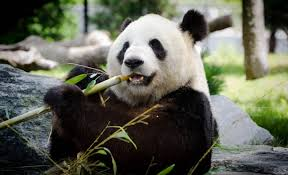

In [42]:
img = cv2.imread('download.jpeg')
print(img.shape)

cv2_imshow(img)

In [43]:
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from efficientnet.preprocessing import center_crop_and_resize
from skimage.io import imread

In [44]:
# define model
model = efn.EfficientNetB0(weights='imagenet')
model.save("keras_raw_efficientnet")

21831680/21826536 [==============================] - 3s 0us/step
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: keras_raw_efficientnet/assets


In [45]:
"""
preprocess inputs
"""

image_size = model.input_shape[1]
x = center_crop_and_resize(img, image_size=image_size)
x = preprocess_input(x, mode='torch')
inputs = np.expand_dims(x, 0)


"""
Make preds w/o onnx
"""

loop_count = 100
start_time = time.time()
for _ in range(loop_count):
  # make preds (raw keras model)
  expected_wo_onnx = model.predict(inputs)
avg_time_wo_onnx = ((time.time() - start_time) / loop_count)

decode_predictions(expected_wo_onnx)

40960/35363 [==================================] - 0s 0us/step


[[('n02510455', 'giant_panda', 0.80991524),
  ('n02134418', 'sloth_bear', 0.007122701),
  ('n02134084', 'ice_bear', 0.0037319448),
  ('n02132136', 'brown_bear', 0.0037293832),
  ('n02133161', 'American_black_bear', 0.002749332)]]

In [46]:
print(expected_wo_onnx.max())
print("Inference time :", avg_time_wo_onnx, "secs")

0.80991524
Inference time : 0.11349005699157715 secs


# With onnx

In [47]:
import keras2onnx

# convert to onnx
output_model_path = "keras_efficientNet.onnx"
onnx_model = keras2onnx.convert_keras(model, model.name)
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 631 -> 334


In [49]:
import onnxruntime

"""
Inference
"""

# gen session
sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)

# gen data feed
data = [inputs.astype(np.float32)]
input_names = sess.get_inputs()
#feed = zip(sorted(i_.name for i_ in input_names), data)

In [54]:
# make preds
loop_count = 1000
times = np.array([])
for i in range(loop_count):
  if i<100:
      feed = zip(sorted(i_.name for i_ in input_names), data)
      expected_w_onnx = sess.run(None, dict(feed))
  else:
      start_time = time.time()
      feed = zip(sorted(i_.name for i_ in input_names), data)
      expected_w_onnx = sess.run(None, dict(feed))
      times = np.append(times, (time.time() - start_time))

decode_predictions(expected_w_onnx[0])

[[('n02510455', 'giant_panda', 0.80991143),
  ('n02134418', 'sloth_bear', 0.007122902),
  ('n02134084', 'ice_bear', 0.0037320785),
  ('n02132136', 'brown_bear', 0.00372954),
  ('n02133161', 'American_black_bear', 0.0027494356)]]

In [56]:
print(expected_w_onnx[0].max())
print("Inference time :", times.mean(), "+-", times.std(), "secs")

0.80991143
Inference time : 0.035051715109083385 +- 0.002557292068056362 secs


# Compaarision

In [57]:
# todo: size

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


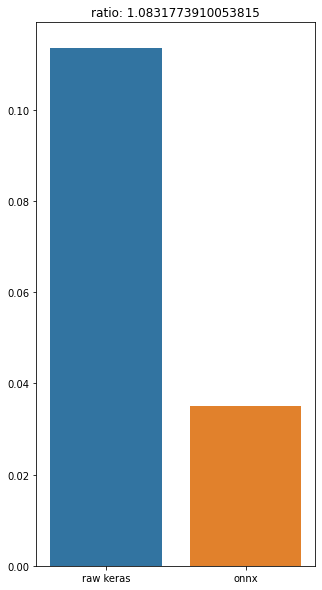

In [59]:
plt.figure(figsize=(5, 10))
sns.color_palette("husl", 8)
sns.barplot(
    ["raw keras", "onnx"],
    [avg_time_wo_onnx, times.mean()],
)


plt.title(f"ratio: {keras_vgg_time_100it/onnx_time_100it}")
plt.show()